In [90]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow_probability as tfp
from utils.plot import *
import seaborn as sns
import matplotlib.pyplot as plt


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [111]:
sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'

# Data

In [21]:
# Fetch and format the mnist data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices(
  (tf.cast(x_train[...,tf.newaxis]/255, tf.float32),
   tf.cast(x_train[...,tf.newaxis]/255, tf.float32)))\
    .shuffle(1000)\
    .batch(256)

eval_ds = tf.data.Dataset.from_tensor_slices(
  (tf.cast(x_test[...,tf.newaxis]/255, tf.float32),
   tf.cast(x_test[...,tf.newaxis]/255, tf.float32)))\
    .batch(256)

# Model

In [22]:
input_shape = (28, 28, 1)
encoded_size = 16
base_depth = 32

In [23]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

In [24]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])

In [25]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=None),
    tfkl.Flatten(),
    tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])

In [26]:
vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

In [27]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negloglik)

_ = vae.fit(train_ds,
            epochs=15,
            validation_data=eval_ds)

Epoch 1/15
235/235 [==============================] - 15s 62ms/step - loss: 223.4404 - val_loss: 170.4131
Epoch 2/15
235/235 [==============================] - 14s 58ms/step - loss: 155.8834 - val_loss: 149.4300
Epoch 3/15
235/235 [==============================] - 14s 58ms/step - loss: 144.9370 - val_loss: 142.5686
Epoch 4/15
235/235 [==============================] - 14s 58ms/step - loss: 139.0609 - val_loss: 136.5030
Epoch 5/15
235/235 [==============================] - 14s 58ms/step - loss: 134.0102 - val_loss: 134.2980
Epoch 6/15
235/235 [==============================] - 14s 58ms/step - loss: 129.7596 - val_loss: 127.5724
Epoch 7/15
235/235 [==============================] - 14s 58ms/step - loss: 126.6845 - val_loss: 125.1294
Epoch 8/15
235/235 [==============================] - 14s 58ms/step - loss: 124.8039 - val_loss: 124.2143
Epoch 9/15
235/235 [==============================] - 14s 58ms/step - loss: 123.6571 - val_loss: 122.6506
Epoch 10/15
235/235 [=========================

In [29]:
# We'll just examine ten random digits.
x = next(iter(eval_ds))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

In [32]:



def display_imgs(x, y=None):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = np.array(x)
    plt.ioff()
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    if y is not None:
        fig.suptitle(np.argmax(y, axis=1))
    for i in range(n):
        axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
        axs.flat[i].axis('off')
    plt.show()
    plt.close()
    plt.ion()

Originals:


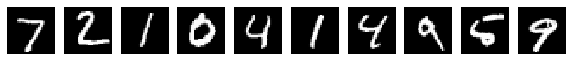

Decoded Random Samples:


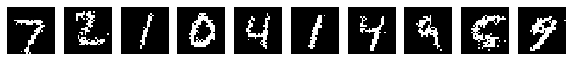

Decoded Modes:


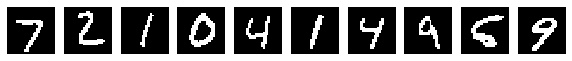

Decoded Means:


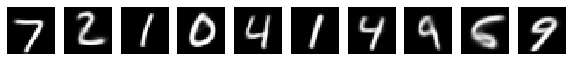

In [33]:
print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

In [34]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder(z)
assert isinstance(xtilde, tfd.Distribution)

Randomly Generated Samples:


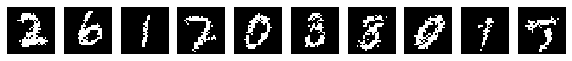

Randomly Generated Modes:


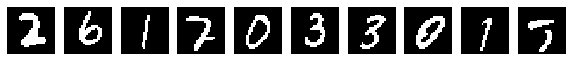

Randomly Generated Means:


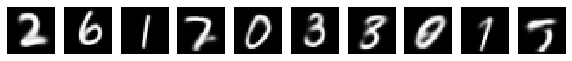

In [35]:
print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

# Examine manifold

In [49]:
x = next(iter(eval_ds))[0][:100]

In [50]:
encoded_x = encoder(x)

In [53]:
encoded_x.shape

TensorShape([100, 16])

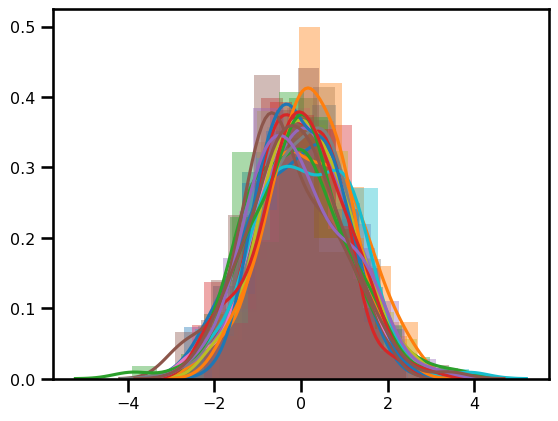

In [140]:
for i in range(16):
    sns.distplot(encoded_x[:, i], kde=True, norm_hist=True)
plt.show()

In [55]:
sum_manifold = tf.reduce_sum(encoded_x, axis=1)

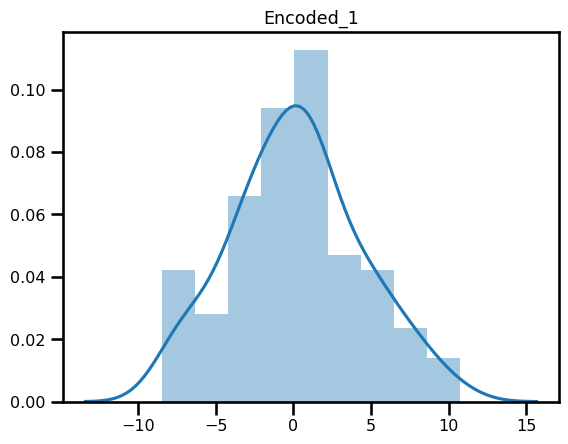

In [145]:
sns.distplot(sum_manifold, kde=True, norm_hist=True)
plt.title("Encoded_1")
plt.show()

# Sample another 100 and compare

In [64]:
x2 = next(iter(eval_ds))[0][100:200]

In [68]:
encoded_x2 = encoder(x2)

In [150]:
encoded_x2.shape

TensorShape([100, 16])

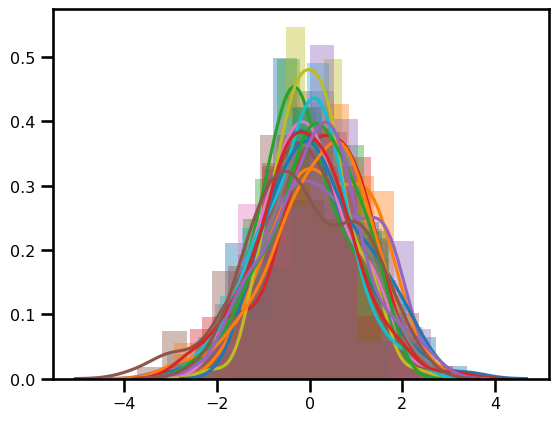

In [122]:
for i in range(16):
    sns.distplot(encoded_x2[:, i], kde=True, norm_hist=True)
plt.show()

In [70]:
sum_manifold2 = tf.reduce_sum(encoded_x2, axis=1)

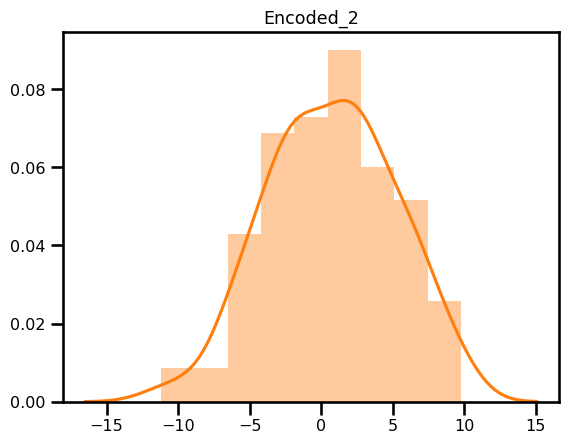

In [147]:
sns.distplot(sum_manifold2, kde=True, norm_hist=True, color=sns.color_palette()[1])
plt.title("Encoded_2")
plt.show()

In [72]:
assert isinstance(encoded_x2, tfd.Distribution)

In [80]:
tf.reduce_mean(
    tfp.distributions.kl_divergence(
        encoded_x, encoded_x2, allow_nan_stats=True, name=None
    )
)

<tf.Tensor: shape=(), dtype=float32, numpy=289.40393>

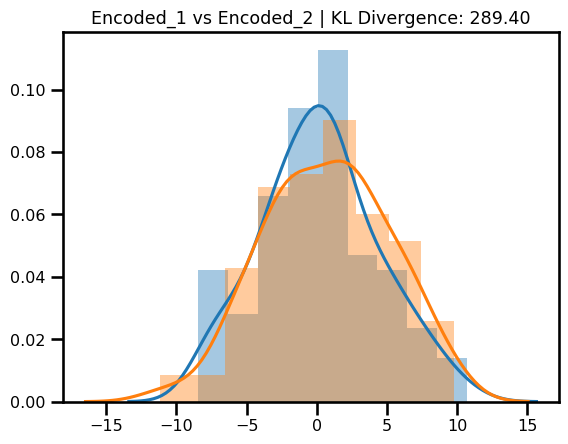

In [143]:
sns.distplot(sum_manifold, kde=True, norm_hist=True)
sns.distplot(sum_manifold2, kde=True, norm_hist=True)
kld = tf.reduce_mean(
    tfp.distributions.kl_divergence(
        encoded_x, encoded_x2, allow_nan_stats=True, name=None
    )
)
plt.title("Encoded_1 vs Encoded_2 | KL Divergence: {:.2f}".format(kld.numpy()))
plt.show()

# What if we feed in 100 points of Normal noise?

In [99]:
x.shape

TensorShape([100, 28, 28, 1])

In [114]:
normal = tfp.distributions.Normal(
    loc=0, scale=1, validate_args=False, allow_nan_stats=True, name='Normal'
)

In [115]:
noise = normal.sample((100, 28, 28, 1))

In [116]:
encoded_noise = encoder(noise)

In [117]:
encoded_noise.shape

TensorShape([100, 16])

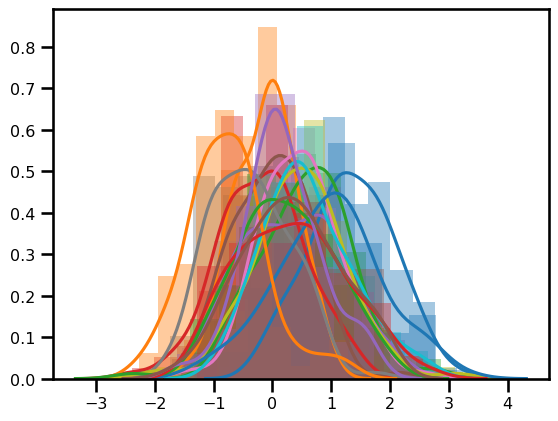

In [118]:
for i in range(16):
    sns.distplot(encoded_noise[:, i], kde=True, norm_hist=True)
plt.show()

In [119]:
sum_manifold_noise = tf.reduce_sum(encoded_noise, axis=1)

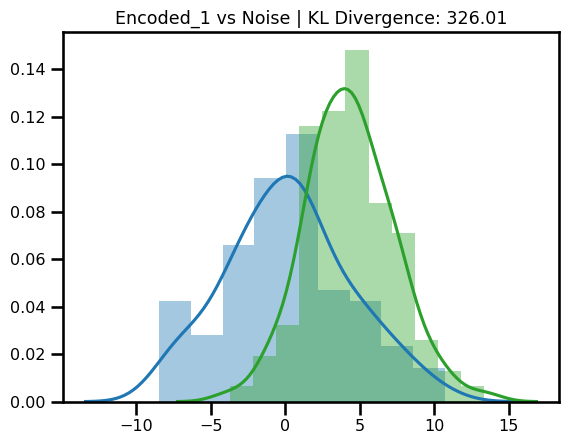

In [148]:
sns.distplot(sum_manifold, kde=True, norm_hist=True, color=sns.color_palette()[0])
sns.distplot(sum_manifold_noise, kde=True, norm_hist=True, color=sns.color_palette()[2])

kld = tf.reduce_mean(
    tfp.distributions.kl_divergence(
        encoded_x, encoded_noise, allow_nan_stats=True, name=None
    )
)
plt.title("Encoded_1 vs Noise | KL Divergence: {:.2f}".format(kld.numpy()))
plt.show()

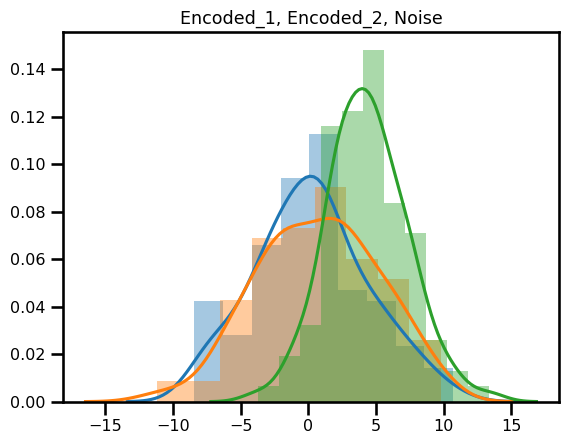

In [149]:
sns.distplot(sum_manifold, kde=True, norm_hist=True, color=sns.color_palette()[0])
sns.distplot(sum_manifold2, kde=True, norm_hist=True, color=sns.color_palette()[1])
sns.distplot(sum_manifold_noise, kde=True, norm_hist=True, color=sns.color_palette()[2])

kld = tf.reduce_mean(
    tfp.distributions.kl_divergence(
        encoded_x, encoded_noise, allow_nan_stats=True, name=None
    )
)
plt.title("Encoded_1, Encoded_2, Noise")
plt.show()

# Synthetic Phantom: 3D Triangle

In [82]:
def tri_1D(n):
    x = np.linspace(0, 1, n)
    return (2/np.pi) * np.arcsin(np.sin(np.pi * x))
def tri_2D(n):
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 1, n)
    xx, yy = np.meshgrid(x, y, sparse=False)
    
    tri_x = (2/np.pi) * np.arcsin(np.sin(np.pi * xx))
    tri_y = (2/np.pi) * np.arcsin(np.sin(np.pi * yy))
    return tri_x * tri_y
def tri_3D(n):
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 1, n)
    z = np.linspace(0, 1, n)
    xx, yy, zz = np.meshgrid(x, y, z, sparse=False)
    
    tri_x = (2/np.pi) * np.arcsin(np.sin(np.pi * xx))
    tri_y = (2/np.pi) * np.arcsin(np.sin(np.pi * yy))
    tri_z = (2/np.pi) * np.arcsin(np.sin(np.pi * zz))
    return tri_x * tri_y * tri_z

In [95]:
n = 128

In [96]:
tri_3d_img = tri_3D(n)

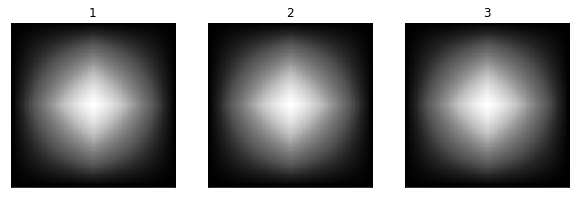

In [98]:
center_vol_plot(tri_3d_img)

# Train model patch-wise

# Synthetic Phantom: Stacked 2D Triangle Fn

In [88]:
tri_2d_img = tri_2D(n)
tri_2d_stack_img = np.stack(
    [tri_2d_img for _ in range(n)]
).transpose(1,2,0)

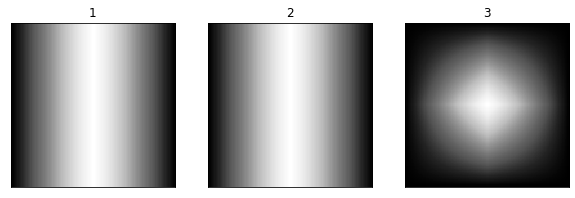

In [89]:
center_vol_plot(tri_2d_stack_img)